In [160]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import date

import regionmask

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader

### get data

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important;}</style>"))

In [283]:
%%time 
## 20CR apcp
filelist=[]
for i in range(1981,2014,1):
    filelist.append(f'/Users/dongxiay/Documents/data/daily/apcp.{i}.nc')
ds1=xr.open_mfdataset(filelist,combine='by_coords')
ds=ds1['apcp'].loc[:,-45:0,100:160]

##Oliver MJO
df=pd.read_csv("/Users/dongxiay/Documents/data/MJO_ot12.csv")
df['time']=pd.to_datetime(df[['year','month','day']])
df=df.set_index('time').drop(columns=['year','month','day'])
df.loc[df['amplitude'].lt(1) ,'phase'] = 0

##NINO3.4
dateparser = lambda d: pd.datetime.strptime(d,'%Y%m%d')
df2=pd.read_csv('http://climexp.knmi.nl/data/inino34_daily.dat',
                skiprows=12,delim_whitespace=True,
                names=['time','enso'],
                parse_dates=['time'],
                date_parser=dateparser)
df2=df2.set_index(df2['time']).drop(columns='time')
df2.loc[df2['enso'].lt(-1) ,'watch'] = -1
df2.loc[df2['enso'].gt(1) ,'watch'] = 1
df2.loc[(df2['enso']>(-1)) & (df2['enso']<(1)),'watch']=0

##merge
dfmjo=df.loc[(df.index >= ds.time.min().values) & (df.index <= ds.time.max().values)][['amplitude','phase']]
dfenso=df2.loc[(df2.index >= ds.time.min().values) & (df2.index <= ds.time.max().values)]['watch']
data=xr.merge([ds,dfmjo.to_xarray(),dfenso.to_xarray()],join='inner').load()

data

<timed exec>:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


CPU times: user 14.8 s, sys: 1.57 s, total: 16.4 s
Wall time: 18.1 s


<xarray.Dataset>
Dimensions:    (time: 11810, lat: 46, lon: 61)
Coordinates:
  * time       (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2013-12-31
  * lat        (lat) float32 -45.0 -44.0 -43.0 -42.0 ... -3.0 -2.0 -1.0 0.0
  * lon        (lon) float32 100.0 101.0 102.0 103.0 ... 157.0 158.0 159.0 160.0
Data variables:
    apcp       (time, lat, lon) float32 0.3625 0.3125 0.2625 ... 1.025 0.875
    amplitude  (time) float64 1.773 1.754 1.641 1.486 ... 0.1155 0.2596 0.4505
    phase      (time) int64 2 2 2 2 2 2 2 2 2 2 3 3 ... 0 0 0 0 0 0 0 0 0 0 0 0
    watch      (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/14)
    long_name:         daily mean 3-hourly accumulated total precipitation at...
    units:             kg/m^2
    GRIB_name:         APCP
    var_desc:          Precipitation amount
    dataset:           NOAA/CIRES/DOE 20th Century Reanalysis version 3mo Dai...
    level_desc:        Surface
    ...                ...
    standard_name:     precipitation_amount
    valid_range:       [  0. 100.]
    statistic_method:  Ensemble mean is calculated by averaging over all 80 e...
    GridType:          Cylindrical Equidistant Projection Grid
    datum:             wgs84
    actual_range:      [ 0.    35.625]

###  Ratio=Prob/baseline

Prob= (number of days when rainfall exceeding the 67% threshold (THR67) for MJO phase 1)
/ (number of days that is in MJO phase 1)

baseline= (number of days when rainfall exceeding the THR67) / (total days for 34 years)

In [284]:
def func(ds):
    return ds['apcp'].count('time') / len(ds['time'])


In [285]:
%%time
THR=0.67

THR_threshold = data['apcp'].where(data['apcp']!=0).chunk(dict(time=-1)).quantile(THR, dim='time')
baseline = data.where(data['apcp'] >= THR_threshold)['apcp'].count('time') / len(data['time'])
baseline=baseline.compute()

result = data.where(data.apcp >= THR_threshold).groupby(data.phase).apply(func).compute()
ratio= result/baseline

CPU times: user 2.5 s, sys: 312 ms, total: 2.81 s
Wall time: 2.69 s


In [ ]:
### mask ocean   
# fmask=xr.open_dataset("/Users/dongxiay/Documents/data/daily/land.nc")
# mask = fmask['land'].loc['1836-01-01',-45:0,100:160]
# ds_l = ds.where(mask)

In [286]:
filename = "/Users/dongxiay/Documents/data/"+'ratio.nc'
ratio.to_netcdf(filename, 'w')

In [288]:
import regionmask
mask = regionmask.defined_regions.natural_earth.countries_110.mask(ratio)
AU_index = regionmask.defined_regions.natural_earth.countries_110.map_keys('AU')
ratio_AU = ratio.where(mask == AU_index)

# cbar_kwargs = {'orientation':'vertical', 'shrink':0.6, 'label':'Ratio'}
# ratio_AU.plot(col='phase', col_wrap=3, size=3,
#              cmap='RdBu', vmin=0, vmax=2,
#              cbar_kwargs=cbar_kwargs)

###  Plot

In [ ]:
# import NCL colormap
! pip install cmaps
import cmaps

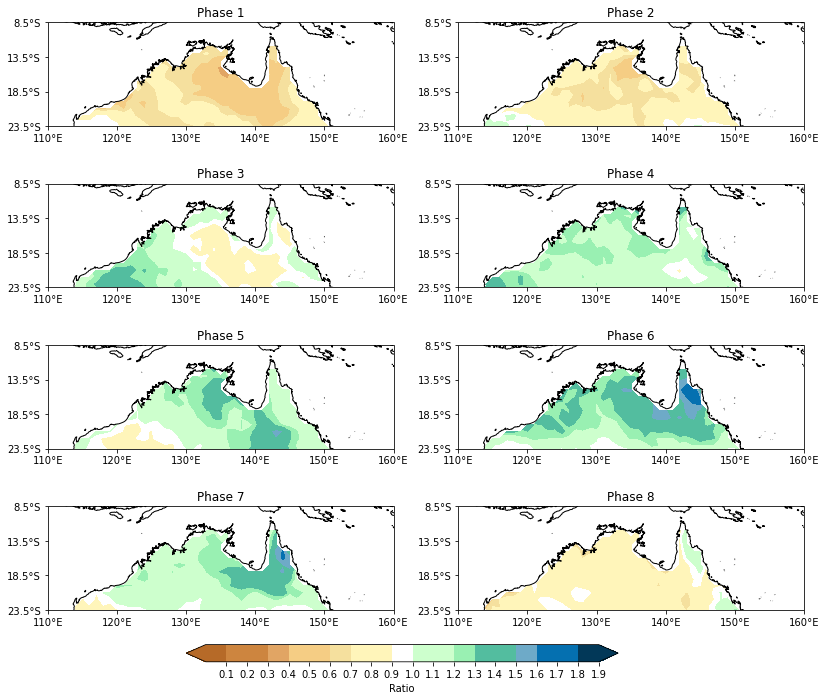

In [102]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
import cartopy.mpl.ticker as cticker 


leftlon, rightlon, lowerlat, upperlat = (110,160,-23.5,-10)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()

title=[]
for i in range(1,9,1):
    title.append(f'Phase {i}')
   
fig = plt.figure(figsize=(12,8))

for i in range(4):
    for j in range(2):
        ax = fig.add_axes([0.1+j*0.475, 1.5-i*0.28, 0.4, 0.3],projection = ccrs.PlateCarree())
#         ax.set_title('({})'.format(title[i,j]),loc='left',fontsize=14)
        ax.set_extent(img_extent, crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE) 
        ax.set_xticks(np.arange(leftlon,rightlon+10,10), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lowerlat,upperlat+5,5), crs=ccrs.PlateCarree())
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.title.set_text(title[i*2+j])
        c = ax.contourf(THR_threshold['lon'],THR_threshold['lat'],ratio_AU[i*2+j+1,:,:],
                        levels=np.arange(0,2,0.1),
                        extend='both' ,
                        cmap=cmaps.precip_diff_12lev,
                        transform=ccrs.PlateCarree()) 
        
#colorbar, You would want to make sure the colorbar always sits in the same axes. 
# To this end, you may create a colorbar axes (cax) outside the loop
fig.colorbar(c, cax=fig.add_axes([0.26, 0.63, 0.5, 0.03 ]),
             orientation='horizontal',  
             label= 'Ratio', 
             ticks=np.arange(0.1,2.1,0.1),
             shrink=0.7)

### monte carlo significant test

Wheeler 2009: Statistical significance for the rainfall composites is judged using a nonparametric resampling approach whereby we successively shift the time sequence of the observed MJO phases relative to the time series
of rainfall and recompute the composite anomalies and probabilities. This time shifting and recalculation is done an arbitrary 1708 times, thereby producing 1708 synthetic realizations of the composite values (the null distribution) with which to compare the actual contemporaneous composite (the observation)

In [224]:
%%time
def create_mjo_ensemble(df_, col, steps):
    df = df_.copy()
    for stp in steps:
        df[f"{col}_{stp}"] = df[col].shift(stp)
        df=df.reset_index()
        df.loc[0:stp-1, f"{col}_{stp}"] = df.loc[len(df)-stp:, f"{col}"].values
        df = df.set_index('time')
    return df
    
# add lagging 
dfmjos = create_mjo_ensemble(dfmjo, 'phase', np.arange(50,len(dfmjo['phase'])-50,7))

CPU times: user 2min 17s, sys: 1min 55s, total: 4min 12s
Wall time: 4min 13s


In [226]:
datam=xr.merge([ds,dfmjos.to_xarray(),dfenso.to_xarray()],join='inner').load()
datam

<xarray.Dataset>
Dimensions:      (time: 11810, lat: 46, lon: 61)
Coordinates:
  * time         (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2013-12-31
  * lat          (lat) float32 -45.0 -44.0 -43.0 -42.0 ... -3.0 -2.0 -1.0 0.0
  * lon          (lon) float32 100.0 101.0 102.0 103.0 ... 158.0 159.0 160.0
Data variables: (12/1712)
    apcp         (time, lat, lon) float32 0.3625 0.3125 0.2625 ... 1.025 0.875
    amplitude    (time) float64 1.773 1.754 1.641 1.486 ... 0.1155 0.2596 0.4505
    phase        (time) int64 2 2 2 2 2 2 2 2 2 2 3 3 ... 0 0 0 0 0 0 0 0 0 0 0
    phase_50     (time) float64 0.0 1.0 1.0 1.0 2.0 2.0 ... 0.0 0.0 0.0 0.0 0.0
    phase_57     (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 8.0 8.0 8.0 1.0 1.0
    phase_64     (time) float64 8.0 8.0 8.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 7.0 7.0
    ...           ...
    phase_11971  (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 2.0 2.0 2.0 2.0 2.0
    phase_11978  (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 8.0 1.0 1.0 1.0 1.0
    phase_11985  (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 8.0 8.0 8.0 8.0 8.0
    phase_11992  (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 6.0 6.0 7.0 7.0 7.0
    phase_11999  (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 6.0
    watch        (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/14)
    long_name:         daily mean 3-hourly accumulated total precipitation at...
    units:             kg/m^2
    GRIB_name:         APCP
    var_desc:          Precipitation amount
    dataset:           NOAA/CIRES/DOE 20th Century Reanalysis version 3mo Dai...
    level_desc:        Surface
    ...                ...
    standard_name:     precipitation_amount
    valid_range:       [  0. 100.]
    statistic_method:  Ensemble mean is calculated by averaging over all 80 e...
    GridType:          Cylindrical Equidistant Projection Grid
    datum:             wgs84
    actual_range:      [ 0.    35.625]

In [270]:
PW="phase"
a=[i for i in list(datam.keys()) if i[:len(PW)]==PW]

In [290]:
ratiom

<xarray.DataArray 'apcp' (iteration: 1709, phase_50: 9, lat: 46, lon: 61)>
array([[[[1.04710745, 1.04938084, 1.04765453, ..., 1.02828809,
          1.02577369, 1.02531161],
         [1.06137544, 1.06323856, 1.06140241, ..., 1.0425094 ,
          1.03800391, 1.03954786],
         [1.05837012, 1.06870682, 1.07118004, ..., 1.05990403,
          1.04987985, 1.05161911],
         ...,
         [0.81725292, 0.85441035, 0.89178071, ..., 0.90431965,
          0.91525685, 0.90034241],
         [0.81593477, 0.83812363, 0.94879478, ..., 0.93127237,
          0.91919759, 0.9124993 ],
         [0.81267941, 0.84873827, 0.97443194, ..., 0.9487227 ,
          0.9553573 , 0.93989115]],

        [[1.04411376, 1.04563458, 1.03168226, ..., 0.99190771,
          0.99218393, 1.00764229],
         [1.03029598, 1.05752203, 1.06030865, ..., 0.95288326,
          0.97860131, 1.00619387],
         [1.02589852, 1.0026535 , 1.01636349, ..., 0.96177746,
          0.9540075 , 0.97804859],
...
         [0.97071231, 1.00258418, 0.98420153, ..., 0.96874382,
          0.98799665, 0.95526006],
         [0.97886955, 0.98168761, 1.05735549, ..., 0.98248127,
          1.01277763, 0.96576231],
         [0.99769356, 1.05368472, 1.06909571, ..., 0.94554473,
          0.95796687, 0.94266244]],

        [[0.87092659, 0.87208153, 0.85926556, ..., 1.05412367,
          1.00420687, 1.01647489],
         [0.88368502, 0.85295563, 0.87556519, ..., 0.99236641,
          1.0116838 , 1.0002011 ],
         [0.89169778, 0.8604035 , 0.86828199, ..., 1.00509872,
          1.00425599, 1.02202367],
         ...,
         [0.8304646 , 0.81995892, 1.00920862, ..., 1.01719542,
          0.97337075, 0.97592889],
         [0.85409571, 0.86188652, 0.98125357, ..., 0.96195466,
          0.94761528, 0.94800193],
         [0.87297798, 0.90542136, 0.94785913, ..., 0.92343371,
          0.91234212, 0.90640737]]]])
Coordinates:
  * lat       (lat) float32 -45.0 -44.0 -43.0 -42.0 -41.0 ... -3.0 -2.0 -1.0 0.0
  * lon       (lon) float32 100.0 101.0 102.0 103.0 ... 157.0 158.0 159.0 160.0
    quantile  float64 0.67
  * phase_50  (phase_50) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
Dimensions without coordinates: iteration

In [279]:
ratiom=ratio.expand_dims({'iteration':len(a)}).copy()

In [280]:
%%time
for i, value in enumerate(a):
    THR=0.67

    THR_threshold = datam['apcp'].where(datam['apcp']!=0).chunk(dict(time=-1)).quantile(THR, dim='time')

    baseline = datam.where(datam['apcp'] >= THR_threshold)['apcp'].count('time') / len(datam['time'])
    baseline=baseline.compute()

    result = datam.where(datam.apcp >= THR_threshold).groupby(datam[value]).apply(func).compute()
    ratio= result/baseline
    ratiom[i,:,:,:]=ratio
    
filename = "/Users/dongxiay/Documents/data/"+'ratiom.nc'
ratiom.to_netcdf(filename, 'w')


CPU times: user 6h 28min 1s, sys: 7min 26s, total: 6h 35min 28s
Wall time: 6h 32min 23s
